# Rodriguez model explanations

## First we need dataframes for every subject

In [18]:
import sys
sys.path.append('../')

%matplotlib inline

# import os
# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = "2"

import pandas as pd
import numpy as np
import utils

pd.set_option('max_colwidth', 800) 

# DEFINE GRAPH
from importlib import reload
reload(utils)


<module 'utils' from '/Users/sbroome/Documents/EquineML/painface-recognition/notebooks/utils.py'>

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

In [3]:
# Data paths
rgb_path = '../data/jpg_128_128_2fps/'
of_path = 'no'

# Hyperparameters
input_width = 128
input_height = 128
seq_length = 10
seq_stride = 10
batch_size = 1
COLOR = True
nb_labels = 2

# Data augmentation
aug_flip = 0
aug_crop = 0
aug_light = 0

subject_ids = pd.read_csv('../metadata/horse_subjects.csv')['Subject'].values
channels = 3

In [4]:
from utils import ArgsProxy
args = ArgsProxy(rgb_path, of_path, input_height, input_width,
                 seq_length, seq_stride, batch_size, nb_labels,
                 aug_flip, aug_crop, aug_light)

In [5]:
import data_handler as dathand
dh = dathand.DataHandler(path=args.data_path,
                         of_path=args.of_path,
                         clip_list_file='videos_overview_missingremoved.csv',
                         data_columns=['Pain'],  # Here one can append f. ex. 'Observer'
                         image_size=(args.input_height, args.input_width),
                         seq_length=args.seq_length,
                         seq_stride=args.seq_stride,
                         batch_size=args.batch_size,
                         color=COLOR,
                         nb_labels=args.nb_labels,
                         aug_flip=args.aug_flip,
                         aug_crop=args.aug_crop,
                         aug_light=args.aug_light)

In [6]:
import utils
subject_dfs = utils.read_or_create_subject_dfs(dh, args, subject_ids)

../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/
../data/jpg_128_128_2fps/


## t3, run4, rodriguez 512u, no aug.

In [7]:
# Choose a model to work on
best_model_path = '../models/BEST_MODEL_rodriguez_adadelta_LSTMunits_512_CONVfilters_None_jpg128_2fps_val4_t3_seq10ss10_4hl_32ubs16_no_aug_run4.h5'
import keras
m = keras.models.load_model(best_model_path)

In [8]:
m.layers

In [9]:
[print(layer.input) for layer in m.layers]

Tensor("input_1:0", shape=(?, 10, 128, 128, 3), dtype=float32)
Tensor("input_1:0", shape=(?, 10, 128, 128, 3), dtype=float32)
Tensor("time_distributed_1/Reshape_1:0", shape=(?, 10, 4, 4, 512), dtype=float32)
Tensor("time_distributed_2/Reshape_2:0", shape=(?, 10, 8192), dtype=float32)
Tensor("dense_1/add:0", shape=(?, 10, 4096), dtype=float32)
Tensor("lstm_1/transpose_1:0", shape=(?, ?, 512), dtype=float32)


[None, None, None, None, None, None]

In [10]:
[print(layer.output) for layer in m.layers]

Tensor("input_1:0", shape=(?, 10, 128, 128, 3), dtype=float32)
Tensor("time_distributed_1/Reshape_1:0", shape=(?, 10, 4, 4, 512), dtype=float32)
Tensor("time_distributed_2/Reshape_2:0", shape=(?, 10, 8192), dtype=float32)
Tensor("dense_1/add:0", shape=(?, 10, 4096), dtype=float32)
Tensor("lstm_1/transpose_1:0", shape=(?, ?, 512), dtype=float32)
Tensor("dense_2/Sigmoid:0", shape=(?, 10, 2), dtype=float32)


[None, None, None, None, None, None]

In [11]:
from keras import backend as K
import tensorflow as tf
    
images = tf.placeholder(tf.float32, [batch_size, args.seq_length, args.input_width, args.input_height, channels])
labels = tf.placeholder(tf.float32, [batch_size, args.seq_length, 2])
model = utils.RodriguezNetwork(images, path=best_model_path)

In [12]:
sess = K.get_session()  # Grab the Keras session where the weights are initialized.

cost = (-1) * tf.reduce_sum(tf.multiply(labels, tf.log(model.preds)), axis=1)
print('model preds: ', model.preds)
print('cost: ', cost)
    
y_c = tf.reduce_sum(tf.multiply(model.preds, labels), axis=1)

print('y_c: ', y_c)

target_conv_layer = model.timedist_vgg # Choose which layer to study

print('tcl: ', target_conv_layer)
print('TYPE tcl: ', type(target_conv_layer))
    
target_conv_layer_grad = tf.gradients(y_c, target_conv_layer)[0]

print('tclg: ', target_conv_layer_grad)
    
gb_grad = tf.gradients(cost, images)[0]  # Guided backpropagation back to input layer

model preds:  Tensor("dense_2_2/Sigmoid:0", shape=(1, 10, 2), dtype=float32)
cost:  Tensor("mul_1:0", shape=(1, 2), dtype=float32)
y_c:  Tensor("Sum_1:0", shape=(1, 2), dtype=float32)
tcl:  Tensor("time_distributed_1_2/transpose_1:0", shape=(1, ?, 4, 4, 512), dtype=float32)
TYPE tcl:  <class 'tensorflow.python.framework.ops.Tensor'>
tclg:  Tensor("gradients/time_distributed_2_2/transpose_grad/transpose:0", shape=(1, ?, 4, 4, 512), dtype=float32)


In [13]:
def run_on_one_sequence(sess, model, batch_img):
    with sess.as_default():
        prob = sess.run(model.preds,
                        feed_dict={images: batch_img,
                                   K.learning_phase(): 0})

        print(prob)
        # print(batch_label)
        gb_grad_value, target_conv_layer_value, target_conv_layer_grad_value = sess.run([gb_grad, target_conv_layer, target_conv_layer_grad],
                      feed_dict={images: batch_img,
                      labels: batch_label,
                      K.learning_phase(): 0})
#         target_conv_layer_value = np.reshape(target_conv_layer_value,
#                                      (1, 10, 128, 128, 3))
#         target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
#                                      (1, 10, 128, 128, 3))
        target_conv_layer_value = np.reshape(target_conv_layer_value,
                                     (1, 10, 4, 4, 512))
        target_conv_layer_grad_value = np.reshape(target_conv_layer_grad_value,
                                     (1, 10, 4, 4, 512))

    utils.visualize_overlays(batch_img, target_conv_layer_value,
                       target_conv_layer_grad_value)


# Rodriguez predictions for subject t3

Chose subject  3
Start index in subject dataframe:  12382
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_4/4_3a/frame_001439.jpg     1
1  data/jpg_128_128_2fps/horse_4/4_3a/frame_001440.jpg     1
2  data/jpg_128_128_2fps/horse_4/4_3a/frame_001441.jpg     1
3  data/jpg_128_128_2fps/horse_4/4_3a/frame_001442.jpg     1
4  data/jpg_128_128_2fps/horse_4/4_3a/frame_001443.jpg     1
5  data/jpg_128_128_2fps/horse_4/4_3a/frame_001444.jpg     1
6  data/jpg_128_128_2fps/horse_4/4_3a/frame_001445.jpg     1
7  data/jpg_128_128_2fps/horse_4/4_3a/frame_001446.jpg     1
8  data/jpg_128_128_2fps/horse_4/4_3a/frame_001447.jpg     1
9  data/jpg_128_128_2fps/horse_4/4_3a/frame_001448.jpg     1
[[[0.43131045 0.5316045 ]
  [0.34673968 0.55622095]
  [0.26958704 0.60889727]
  [0.31571275 0.5144606 ]
  [0.3535038  0.5269667 ]
  [0.336538   0.5744937 ]
  [0.27776003 0.5577648 ]
  [0.2896482  0.50117445]
  [0.24454626 0.6698809 ]
  [0.18686904 0.65571874]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


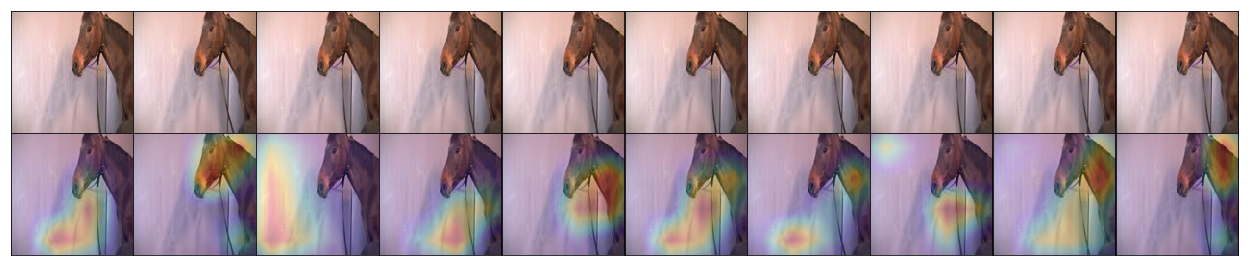

In [14]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=3)
run_on_one_sequence(sess, model, batch_img)

Chose subject  3
Start index in subject dataframe:  13030
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_4/4_4a/frame_000355.jpg     1
1  data/jpg_128_128_2fps/horse_4/4_4a/frame_000356.jpg     1
2  data/jpg_128_128_2fps/horse_4/4_4a/frame_000357.jpg     1
3  data/jpg_128_128_2fps/horse_4/4_4a/frame_000358.jpg     1
4  data/jpg_128_128_2fps/horse_4/4_4a/frame_000359.jpg     1
5  data/jpg_128_128_2fps/horse_4/4_4a/frame_000360.jpg     1
6  data/jpg_128_128_2fps/horse_4/4_4a/frame_000361.jpg     1
7  data/jpg_128_128_2fps/horse_4/4_4a/frame_000362.jpg     1
8  data/jpg_128_128_2fps/horse_4/4_4a/frame_000363.jpg     1
9  data/jpg_128_128_2fps/horse_4/4_4a/frame_000364.jpg     1
[[[0.07237498 0.91078186]
  [0.04479095 0.93607855]
  [0.01538592 0.9055408 ]
  [0.01084344 0.9329224 ]
  [0.01445243 0.9190005 ]
  [0.01561134 0.9355284 ]
  [0.01109073 0.9438212 ]
  [0.01088325 0.93994874]
  [0.0132089  0.93559015]
  [0.01088737 0.9415313 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


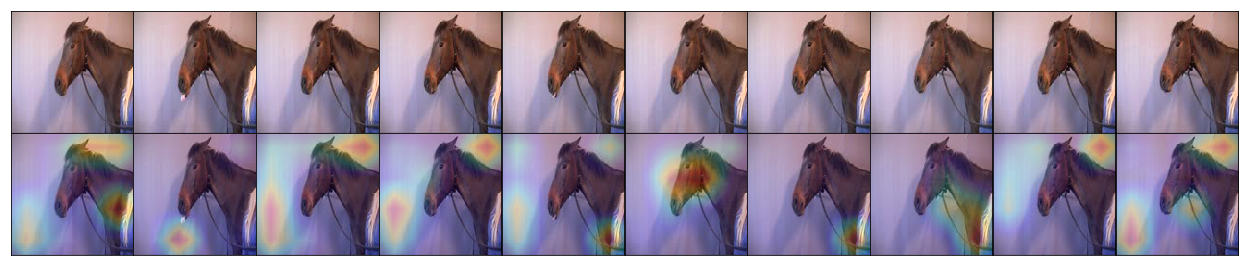

In [15]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=3, start_index=13030)
run_on_one_sequence(sess, model, batch_img)


Chose subject  3
Start index in subject dataframe:  13442
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_4/4_4a/frame_000767.jpg     1
1  data/jpg_128_128_2fps/horse_4/4_4a/frame_000768.jpg     1
2  data/jpg_128_128_2fps/horse_4/4_4a/frame_000769.jpg     1
3  data/jpg_128_128_2fps/horse_4/4_4a/frame_000770.jpg     1
4  data/jpg_128_128_2fps/horse_4/4_4a/frame_000771.jpg     1
5  data/jpg_128_128_2fps/horse_4/4_4a/frame_000772.jpg     1
6  data/jpg_128_128_2fps/horse_4/4_4a/frame_000773.jpg     1
7  data/jpg_128_128_2fps/horse_4/4_4a/frame_000774.jpg     1
8  data/jpg_128_128_2fps/horse_4/4_4a/frame_000775.jpg     1
9  data/jpg_128_128_2fps/horse_4/4_4a/frame_000776.jpg     1
[[[0.07602672 0.8903278 ]
  [0.02952599 0.930047  ]
  [0.04451831 0.9353891 ]
  [0.020286   0.96815926]
  [0.03943163 0.97633785]
  [0.01602642 0.9633911 ]
  [0.02787844 0.9615602 ]
  [0.03760802 0.97253966]
  [0.02833209 0.96997213]
  [0.03573671 0.9675868 ]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


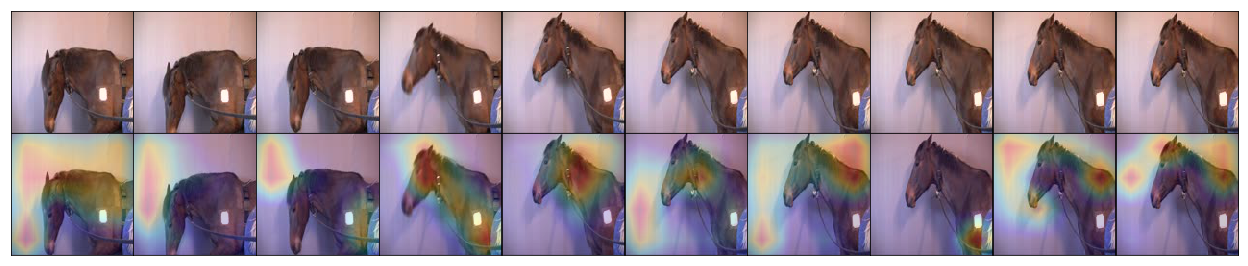

In [16]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=3, start_index=13442)
run_on_one_sequence(sess, model, batch_img)


Chose subject  3
Start index in subject dataframe:  12089
                                                  Path  Pain
0  data/jpg_128_128_2fps/horse_4/4_3a/frame_001146.jpg     1
1  data/jpg_128_128_2fps/horse_4/4_3a/frame_001147.jpg     1
2  data/jpg_128_128_2fps/horse_4/4_3a/frame_001148.jpg     1
3  data/jpg_128_128_2fps/horse_4/4_3a/frame_001149.jpg     1
4  data/jpg_128_128_2fps/horse_4/4_3a/frame_001150.jpg     1
5  data/jpg_128_128_2fps/horse_4/4_3a/frame_001151.jpg     1
6  data/jpg_128_128_2fps/horse_4/4_3a/frame_001152.jpg     1
7  data/jpg_128_128_2fps/horse_4/4_3a/frame_001153.jpg     1
8  data/jpg_128_128_2fps/horse_4/4_3a/frame_001154.jpg     1
9  data/jpg_128_128_2fps/horse_4/4_3a/frame_001155.jpg     1
[[[0.14482912 0.65582526]
  [0.12438512 0.71365756]
  [0.5284901  0.41781121]
  [0.35073915 0.39810786]
  [0.45286024 0.43530583]
  [0.28989458 0.47506627]
  [0.39532736 0.36109555]
  [0.5224013  0.53788584]
  [0.5921401  0.39772254]
  [0.75667685 0.24890275]]]


/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "
/Users/sbroome/miniconda2/envs/py365/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warnings.warn(message, mplDeprecation, stacklevel=1)


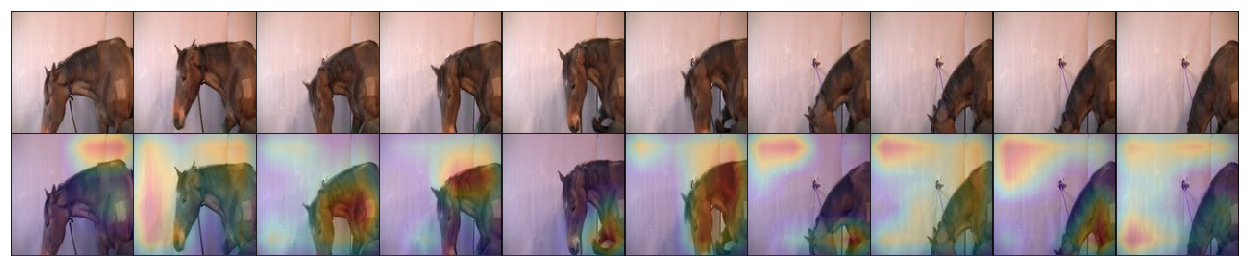

In [17]:
batch_img, batch_label = utils.data_for_one_random_sequence_5D(args, subject_dfs, computer='local',subject=3, start_index=12089)
run_on_one_sequence(sess, model, batch_img)
